In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 21.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=380bb083f8e7197def9255b7547248b79bdfba6285477a91894f278aee3e742f
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
stocks = pd.read_csv("combined_stock_inputs.csv")
stocks

,Ticker,Date,Sentiment_Weighted,Sentiment_MA,Tweets,Tweets_MA,Adj Close,Percent_Change,Percent_Change_Bin
0,aal,11-03-2016,0.363636,0.363636,33,33.000000,40.697006,0.282561,1
1,aal,14-03-2016,1.105263,0.457310,19,25.000000,40.812000,-1.127042,0
2,aal,15-03-2016,0.466667,0.523977,45,25.000000,40.352032,0.474956,1
3,aal,16-03-2016,0.282353,0.618094,85,49.666667,40.543686,-0.496336,0
4,aal,17-03-2016,0.121951,0.290324,41,57.000000,40.342453,3.182904,2
...,...,...,...,...,...,...,...,...,...
4698,wdc,10-06-2016,0.714286,0.837316,35,58.333333,40.854404,-1.216631,0
4699,wdc,13-06-2016,0.837838,1.014640,37,30.000000,40.357357,0.259286,1
4700,wdc,14-06-2016,0.815789,0.926209,38,30.333333,40.461998,-0.301720,0
4701,wdc,15-06-2016,0.766667,0.806765,30,35.000000,40.339916,0.345867,1


In [4]:
stocks['Date']= pd.to_datetime(stocks['Date'], format='%d-%m-%Y', errors='coerce')
stocks['Date'].dtype

dtype('<M8[ns]')

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkML').getOrCreate()

In [6]:
df= spark.createDataFrame(stocks)

In [7]:
df.show()

+------+-------------------+------------------+------------+------+-----------+-----------+--------------+------------------+
|Ticker|               Date|Sentiment_Weighted|Sentiment_MA|Tweets|  Tweets_MA|  Adj Close|Percent_Change|Percent_Change_Bin|
+------+-------------------+------------------+------------+------+-----------+-----------+--------------+------------------+
|   aal|2016-03-11 00:00:00|       0.363636364| 0.363636364|    33|       33.0|40.69700623|   0.282561446|                 1|
|   aal|2016-03-14 00:00:00|       1.105263158| 0.457309942|    19|       25.0|40.81200027|  -1.127042448|                 0|
|   aal|2016-03-15 00:00:00|       0.466666667| 0.523976608|    45|       25.0|40.35203171|   0.474955528|                 1|
|   aal|2016-03-16 00:00:00|       0.282352941| 0.618094255|    85|49.66666667|40.54368591|  -0.496336003|                 0|
|   aal|2016-03-17 00:00:00|        0.12195122| 0.290323609|    41|       57.0|  40.342453|   3.182903706|            

In [8]:
from pyspark.sql.functions import col

In [9]:
from pyspark.ml.feature import VectorAssembler

# Select the columns from the DataFrame
X_train = df.select("Sentiment_Weighted", "Sentiment_MA", "Tweets", "Tweets_MA", "Adj Close", "Percent_Change_Bin")
y_train = df.select("Percent_Change")

# Convert the DataFrame to a RDD
X_train_rdd = X_train.rdd
y_train_rdd = y_train.rdd

# Use VectorAssembler to combine the columns into a single feature vector column
assembler = VectorAssembler(inputCols=['Sentiment_Weighted', 'Sentiment_MA', 'Tweets', 'Tweets_MA', 'Adj Close', 'Percent_Change_Bin'], outputCol='features')
X_train_vector = assembler.transform(X_train)

In [10]:
df1 = assembler.transform(df)

In [11]:
df1.show()

+------+-------------------+------------------+------------+------+-----------+-----------+--------------+------------------+--------------------+
|Ticker|               Date|Sentiment_Weighted|Sentiment_MA|Tweets|  Tweets_MA|  Adj Close|Percent_Change|Percent_Change_Bin|            features|
+------+-------------------+------------------+------------+------+-----------+-----------+--------------+------------------+--------------------+
|   aal|2016-03-11 00:00:00|       0.363636364| 0.363636364|    33|       33.0|40.69700623|   0.282561446|                 1|[0.363636364,0.36...|
|   aal|2016-03-14 00:00:00|       1.105263158| 0.457309942|    19|       25.0|40.81200027|  -1.127042448|                 0|[1.105263158,0.45...|
|   aal|2016-03-15 00:00:00|       0.466666667| 0.523976608|    45|       25.0|40.35203171|   0.474955528|                 1|[0.466666667,0.52...|
|   aal|2016-03-16 00:00:00|       0.282352941| 0.618094255|    85|49.66666667|40.54368591|  -0.496336003|            

In [12]:
df2= df1.select("features", "Percent_Change")

In [13]:
df2.show()

+--------------------+--------------+
|            features|Percent_Change|
+--------------------+--------------+
|[0.363636364,0.36...|   0.282561446|
|[1.105263158,0.45...|  -1.127042448|
|[0.466666667,0.52...|   0.474955528|
|[0.282352941,0.61...|  -0.496336003|
|[0.12195122,0.290...|   3.182903706|
|[0.409836066,0.27...|   0.069069855|
|[0.9,0.625925926,...|   1.075510833|
|[0.333333333,0.61...|   0.072560941|
|[0.8,0.677777778,...|  -0.894169973|
|[0.707317073,0.61...|  -3.633246946|
|[0.416666667,0.64...|  -0.379574381|
|[0.864864865,0.76...|  -1.117560772|
|[0.452991453,0.78...|   -0.07706129|
|[0.355263158,0.55...|  -1.388203661|
|[0.318181818,0.37...|    0.36498388|
|[0.306451613,0.32...|   0.597401856|
|[0.194444444,0.45...|   1.187687764|
|[0.40562249,0.394...|   1.913761722|
|[0.253164557,0.28...|   3.079596118|
|[0.462962963,0.37...|  -0.631488584|
+--------------------+--------------+
only showing top 20 rows



In [14]:
df.take(3)

[Row(Ticker='aal', Date=datetime.datetime(2016, 3, 11, 0, 0), Sentiment_Weighted=0.363636364, Sentiment_MA=0.363636364, Tweets=33, Tweets_MA=33.0, Adj Close=40.69700623, Percent_Change=0.282561446, Percent_Change_Bin=1),
 Row(Ticker='aal', Date=datetime.datetime(2016, 3, 14, 0, 0), Sentiment_Weighted=1.105263158, Sentiment_MA=0.457309942, Tweets=19, Tweets_MA=25.0, Adj Close=40.81200027, Percent_Change=-1.127042448, Percent_Change_Bin=0),
 Row(Ticker='aal', Date=datetime.datetime(2016, 3, 15, 0, 0), Sentiment_Weighted=0.466666667, Sentiment_MA=0.523976608, Tweets=45, Tweets_MA=25.0, Adj Close=40.35203171, Percent_Change=0.474955528, Percent_Change_Bin=1)]

In [15]:
from pyspark.sql.functions import *
print(df.stat.corr('Sentiment_Weighted','Percent_Change'))
print(df.stat.corr('Sentiment_MA','Percent_Change'))
print(df.stat.corr('Tweets','Percent_Change'))
print(df.stat.corr('Tweets_MA','Percent_Change'))
print(df.stat.corr('Adj Close','Percent_Change'))
print(df.stat.corr('Percent_Change_Bin','Percent_Change'))

-0.016387092392406412
-0.03864494378907382
-0.0008509208276530713
-0.005698015259264397
-0.038419675806204104
0.5954081336184662


In [16]:
from pyspark.ml.regression import LinearRegression
train_data,test_data=df2.randomSplit([0.8,0.2])
applyml=LinearRegression(featuresCol='features', labelCol='Percent_Change')
applyml=applyml.fit(train_data)

In [17]:
predict=applyml.evaluate(test_data)
predict.predictions.show()

+--------------------+--------------+-------------------+
|            features|Percent_Change|         prediction|
+--------------------+--------------+-------------------+
|[-1.0,-1.0,1.0,1....|   1.053884179| 0.9907759316400973|
|[-0.428571429,0.5...|   0.230070681| 0.8124770205588292|
|[-0.4,-0.06211180...|   -4.49061304|-1.4536970628953392|
|[-0.2,0.522657952...|  -2.557419304|-1.4952551212219103|
|[-0.166666667,0.4...|   1.232456767| 0.8544332926692233|
|[-0.142857143,0.6...|   2.853461292| 3.1454917838753547|
|[-0.066666667,0.2...|    1.11332288| 0.8586525391548241|
|[-0.043478261,0.7...|  -0.174652592|-1.4578755964738035|
|[0.0,0.405128205,...|  -0.799859461|-1.4496529818615302|
|[0.0,0.517598344,...|  -2.592681568|-1.4816418517786156|
|[0.0,0.611111111,...|   1.700277737| 0.8555164515107441|
|[0.0,0.788888889,...|  -0.939107564| -1.504163621554662|
|[0.1,-0.363492063...|  -3.127600549|-1.4252197163285618|
|[0.133333333,0.39...|  -0.065764367|-1.4025046568845987|
|[0.181818182,

In [18]:
print(predict.meanAbsoluteError)
print(predict.meanSquaredError)
print(predict.rootMeanSquaredError)
print(predict.r2)

0.8202459355936299
3.959378576847427
1.989818729645348
0.3555375427205414


In [19]:
'''x_val= stocks['Ticker']
y1_val= stocks['Percent_Change']
y2_val= predict.predictions['prediction']

fig, ax = plt.subplots()
ax.plot(x_val, y1_val, label='Actual percentage change', color='orange')
ax.plot(x_val, y2_val, label='Predicted percent change', color='green')

ax.set_xlabel('Stocks')
ax.set_ylabel('Percentage change')
ax.legend()
plt.show()'''

"x_val= stocks['Ticker']\ny1_val= stocks['Percent_Change']\ny2_val= predict.predictions['prediction']\n\nfig, ax = plt.subplots()\nax.plot(x_val, y1_val, label='Actual percentage change', color='orange')\nax.plot(x_val, y2_val, label='Predicted percent change', color='green')\n\nax.set_xlabel('Stocks')\nax.set_ylabel('Percentage change')\nax.legend()\nplt.show()"

(1121, 4) (1121,)
(3582, 4) (3582,)


0.208821887213847




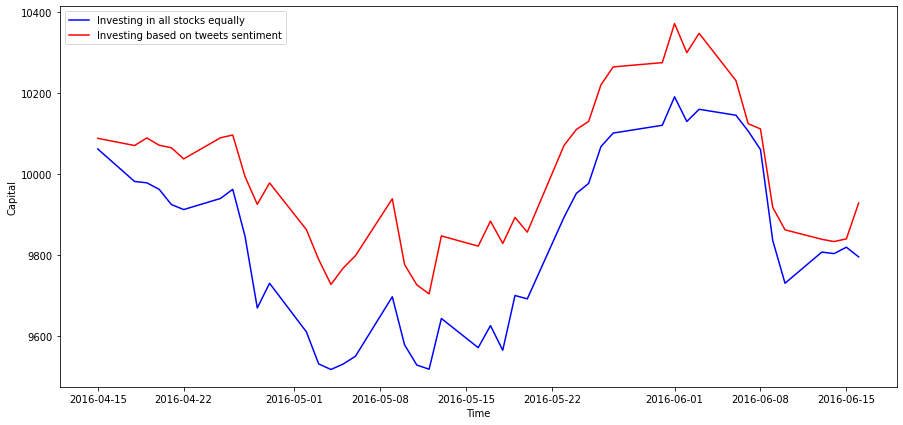

In [21]:
#Visualising the difference in profit by investing in all stocks equally vs stocks chosen by the bot

from sklearn.ensemble import RandomForestClassifier

# Sort values in stock sentiment/pricing data by date and ticker name 
stocks = pd.read_csv("/content/drive/MyDrive/combined_stock_inputs.csv")
stocks['Date']= pd.to_datetime(stocks['Date'], format='%d-%m-%Y', errors='coerce')

# Use first 2 months of data as test data
d_train = stocks.loc[stocks['Date'] < datetime.datetime(year=2016, month=4, day=15)].reset_index(drop=True)

# Use last 2-3 months as test data 
d_test = stocks.loc[stocks['Date'] >= datetime.datetime(year=2016, month=4, day=15)].reset_index(drop=True)

# Remove extra columns from train data 
X_train = d_train[['Sentiment_Weighted', 'Sentiment_MA', 'Tweets', 'Tweets_MA']].values
y_train = d_train['Percent_Change_Bin'].values

# Remove extra solumns from test data 
X_test = d_test[['Sentiment_Weighted', 'Sentiment_MA', 'Tweets', 'Tweets_MA']].values
y_test = d_test['Percent_Change_Bin'].values

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print('\n')

# Define random forest classifier
model = RandomForestClassifier(random_state=1)

# Train model with training data
model.fit(X_train, y_train)

# Predict the test data 
preds = model.predict(X_test)

# Print the percent of predictions that resulted in investing in a losing stock
print(len(np.where( (preds>0) & (y_test==0) )[0])/len(preds))
print('\n')

# Add predictions to test dataset 
d_test['Prediction'] = preds

# Initialize starting capital to test model effectiveness
bot_capital = 10000
long_capital = 10000

# Add capital as first data points
bots = [bot_capital]
longs = [long_capital]

# Get unique dates
dates = d_test['Date'].sort_values().unique()

# For each date
for date in dates:
    # filter dataframe to date
    temp = d_test[d_test['Date']==date]
    
    # Calculate profit from investing equal parts to all tickers in timeframe
    long_capital = long_capital + ((long_capital/len(temp)) * (temp['Percent_Change']/100)).sum()
    
    # Calculate profit from using the Twitter bot to determine what stocks to invest in 
    temp = temp[temp['Prediction']>0]
    bot_capital = bot_capital + ((bot_capital/len(temp)) * (temp['Percent_Change']/100)).sum()
    
    # Keep track of the account totals over time 
    longs.append(long_capital)
    bots.append(bot_capital)
    
    
# Plot the accounts balances over time
plt.figure(figsize=(15,7))
plt.xlabel("Time")
plt.ylabel("Capital")
plt.plot(dates, longs[1:], c='b', label='Investing in all stocks equally')
plt.plot(dates, bots[1:], c='r', label='Investing based on tweets sentiment')
plt.legend()
plt.show()

# Show the return from each account over time 
#print('Long-Term Investment:', round(longs[-1],2), '(', round((longs[-1]-longs[0])/longs[0]*100,2), '% )')
#print('Bot Trading:', round(bots[-1],2), '(', round((bots[-1]-bots[0])/bots[0]*100,2), '% )')